In [138]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import cv2

import sys
sys.path.append('../ZoeDepth')
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image

%matplotlib inline

In [139]:
zoe = torch.hub.load("../ZoeDepth", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in C:\Users\csirlin/.cache\torch\hub\intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [140]:
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w" #@param {type:"string"}
# img = get_image_from_url(img_url)
img = Image.open('depth.jpg')
depth = zoe.infer_pil(img)
img = np.array(img)

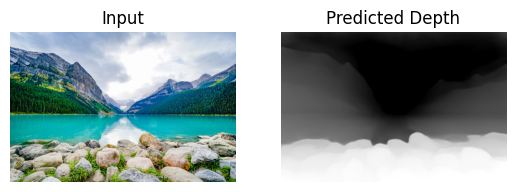

In [141]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

In [142]:
# print info about the depth image. depth is in meters
print(depth.shape, depth.max(), depth.min(), depth.mean())

(720, 1080) 5.4121437 1.1850127 3.3651345


In [143]:
x_map, y_map = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))
print(x_map)

[[   0    1 ... 1078 1079]
 [   0    1 ... 1078 1079]
 ...
 [   0    1 ... 1078 1079]
 [   0    1 ... 1078 1079]]


In [144]:
# compute shifted image
fov = 60
fov_rad = fov * math.pi / 180
x = depth.shape[1] # width in pixels
eye_dist = 0.063 # on average, eyes are 63mm apart
x_displaced = x_map + x*eye_dist/(2*depth*np.tan(fov_rad/2))
x_displaced = np.clip(x_displaced, 0, x-1)
warped_image = cv2.remap(img, x_displaced.astype(np.float32), y_map.astype(np.float32), cv2.INTER_LINEAR)

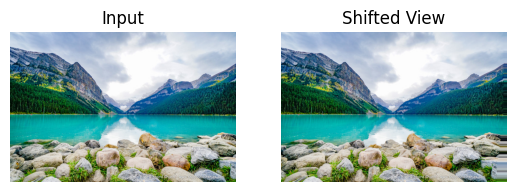

In [145]:
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, warped_image], ['Input', 'Shifted View']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

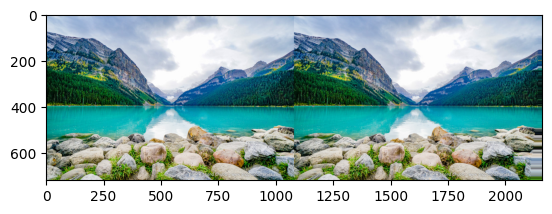

In [146]:
# look closely to get the magic eye/3D effect
img_and_warped = np.hstack((img, warped_image))
plt.imshow(img_and_warped)

<AxesSubplot: xlabel='x (microns)', ylabel='y (microns)'>

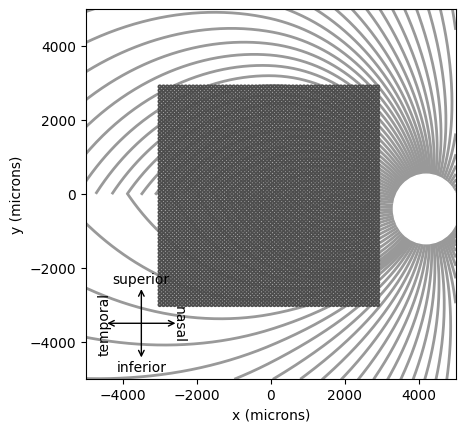

In [147]:
### pulse2percept time ###

# start with a really idealistic model with tons of electrodes
full_array = p2p.implants.ElectrodeArray([])
e_count = 0
for i in range(-3000, 3000, 100):
    for j in range(-3000, 3000, 100):
        full_array.add_electrode(e_count, p2p.implants.DiskElectrode(i, j, z=0, r=25))
        e_count += 1
full_array.plot()
p2p.models.AxonMapModel().plot()

<AxesSubplot: xlabel='x (microns)', ylabel='y (microns)'>

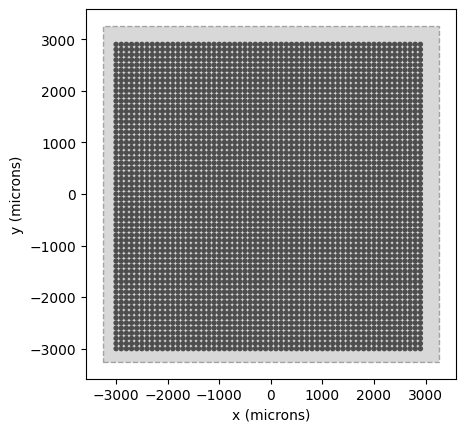

In [148]:
model = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
model.build()
model.plot()
full_array.plot()

In [149]:
def get_percept_data_from_image(image):
    full_prosthesis = p2p.implants.ProsthesisSystem(full_array, p2p.stimuli.ImageStimulus(image))
    percept = model.predict_percept(full_prosthesis)
    return percept.data

percept_left = get_percept_data_from_image(img)
percept_right = get_percept_data_from_image(warped_image)

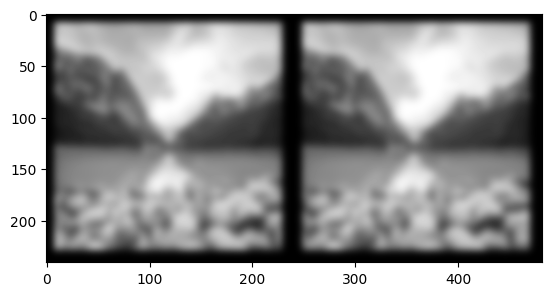

In [150]:
# percepts still have the effect!
percept_side_by_side = np.hstack((percept_left, percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

In [151]:
# now try argus II
implant = p2p.implants.ArgusII()
model = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
model.build()

implant.stim = p2p.stimuli.ImageStimulus(img)
percept_left = model.predict_percept(implant)
implant.stim = p2p.stimuli.ImageStimulus(warped_image)
percept_right = model.predict_percept(implant)

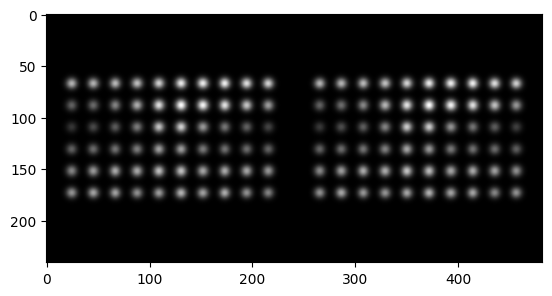

In [152]:
# resulting view is basically useless
percept_side_by_side = np.hstack((percept_left.data, percept_right.data))
plt.imshow(percept_side_by_side, cmap='gray')

In [153]:
# full_array = p2p.implants.ElectrodeArray([])
# e_count = 0
# for i in range(-3000, 3000, 100):
#     for j in range(-3000, 3000, 100):
#         full_array.add_electrode(e_count, p2p.implants.DiskElectrode(i, j, z=0, r=25))
#         e_count += 1
# full_array.plot()
# p2p.models.AxonMapModel().plot()

# model = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
# model.build()
# model.plot()
# full_array.plot()

# def get_percept_data_from_image(image):
#     full_prosthesis = p2p.implants.ProsthesisSystem(full_array, p2p.stimuli.ImageStimulus(image))
#     percept = model.predict_percept(full_prosthesis)
#     return percept.data

# percept_left = get_percept_data_from_image(img)
# percept_right = get_percept_data_from_image(warped_image)

# percept_side_by_side = np.hstack((percept_left, percept_right))
# plt.imshow(percept_side_by_side, cmap='gray')

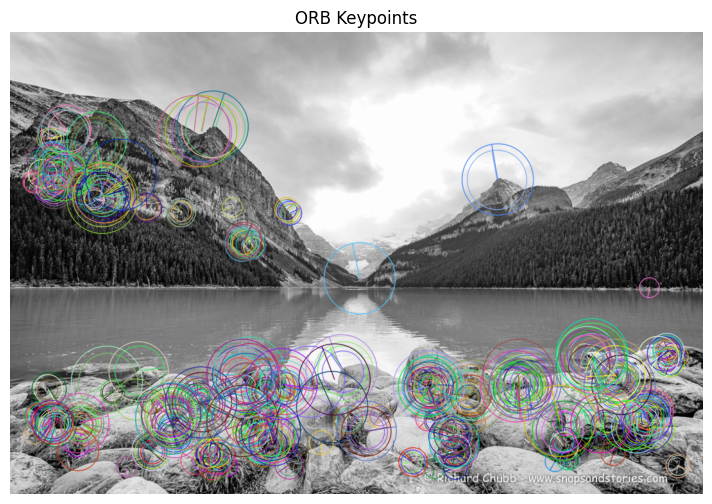

In [154]:
# Load the image
image_path = "depth.jpg"  # Change to your image path
img_kp = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints, descriptors = orb.detectAndCompute(img_kp, None)

# Draw keypoints on the image
img_keypoints = cv2.drawKeypoints(img_kp, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.figure(figsize=(10, 6))
plt.imshow(img_keypoints, cmap='gray')
plt.title("ORB Keypoints")
plt.axis("off")
plt.show()

In [155]:
keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)

for keypoint in keypoints:
    print(keypoint.pt, keypoint.response)

(69.60000610351562, 616.800048828125) 0.0038904931861907244
(70.56000518798828, 616.3200073242188) 0.003807668574154377
(69.0, 618.0) 0.0034862197935581207
(652.0, 558.0) 0.0032359694596379995
(222.0, 654.0) 0.003174096578732133
(294.0, 579.0) 0.003105467651039362
(70.84800720214844, 616.8960571289062) 0.0030621669720858335
(328.0, 668.0) 0.002987281186506152
(255.0, 628.0) 0.0029844227246940136
(1024.0, 513.0) 0.0029661590233445168
(70.50241088867188, 613.7857055664062) 0.0029136089142411947
(294.0, 578.4000244140625) 0.00286081968806684
(693.0, 656.0) 0.002835240913555026
(641.0, 541.0) 0.002800676738843322
(946.0, 539.0) 0.002646259032189846
(926.0, 611.0) 0.0025712193455547094
(325.0, 679.0) 0.0025334390811622143
(255.60000610351562, 628.800048828125) 0.0023468753788620234
(430.0, 553.0) 0.0023049747105687857
(312.0, 682.0) 0.00229682051576674
(652.800048828125, 558.0) 0.002273408928886056
(294.0, 581.0) 0.0022051497362554073
(433.0, 278.0) 0.0022019147872924805
(222.00001525878906

In [156]:
keypoint_positions = [kp.pt for kp in keypoints][:100]
print(keypoint_positions)
keypoint_positions_shifted = [(j - x*eye_dist/(2*depth[int(i)][int(j)]*np.tan(fov_rad/2)), i) for (j, i) in keypoint_positions]

print(keypoint_positions_shifted)

[(69.60000610351562, 616.800048828125), (70.56000518798828, 616.3200073242188), (69.0, 618.0), (652.0, 558.0), (222.0, 654.0), (294.0, 579.0), (70.84800720214844, 616.8960571289062), (328.0, 668.0), (255.0, 628.0), (1024.0, 513.0), (70.50241088867188, 613.7857055664062), (294.0, 578.4000244140625), (693.0, 656.0), (641.0, 541.0), (946.0, 539.0), (926.0, 611.0), (325.0, 679.0), (255.60000610351562, 628.800048828125), (430.0, 553.0), (312.0, 682.0), (652.800048828125, 558.0), (294.0, 581.0), (433.0, 278.0), (222.00001525878906, 654.0), (945.6000366210938, 538.800048828125), (98.0, 209.0), (693.6000366210938, 654.0), (384.0, 628.0), (710.0, 653.0), (626.0, 670.0), (159.0, 561.0), (114.0, 609.0), (696.0, 656.0), (254.8800048828125, 627.8400268554688), (294.0, 580.800048828125), (978.0, 621.0), (37.0, 235.0), (813.0, 552.0), (105.0, 644.0), (309.0, 658.0), (714.0, 569.0), (681.0, 622.0), (1023.0, 510.0), (663.0, 605.0), (428.5440368652344, 552.9600830078125), (221.0, 576.0), (58.0, 557.0), 

(720, 1080, 3)


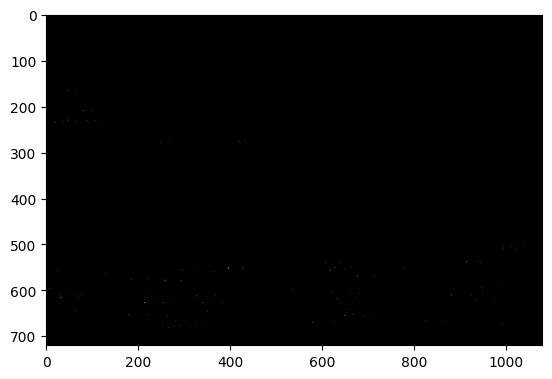

In [157]:
empty = np.zeros(img.shape)
print(img.shape)
for (j, i) in keypoint_positions:
    empty[int(i)][int(j)] = [1, 0, 0]
for (j, i) in keypoint_positions_shifted:
    empty[int(i)][int(j)] = [0, 1, 1]
plt.imshow(empty)

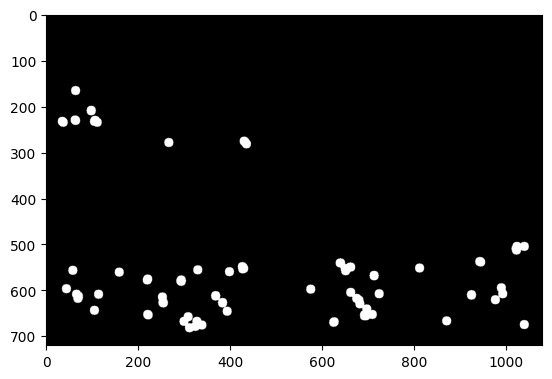

In [158]:
keypoints_left = np.zeros(img.shape)
for (j, i) in keypoint_positions:
    cv2.circle(keypoints_left, (int(j), int(i)), radius=10, color=(255, 255, 255), thickness=-1)
plt.imshow(keypoints_left)

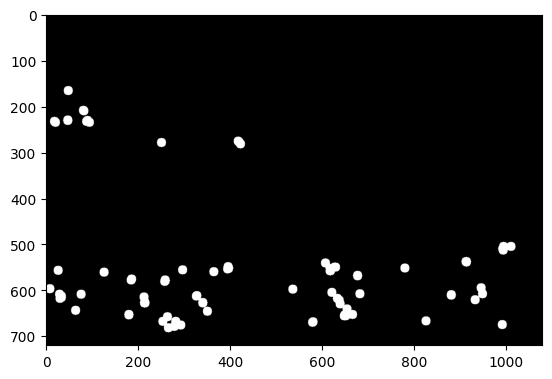

In [159]:
keypoints_right = np.zeros(img.shape)
for (j, i) in keypoint_positions_shifted:
    cv2.circle(keypoints_right, (int(j), int(i)), radius=10, color=(255, 255, 255), thickness=-1)
plt.imshow(keypoints_right)

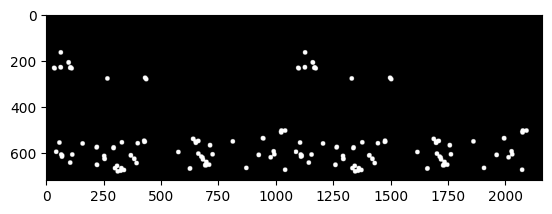

In [160]:
percept_side_by_side = np.hstack((keypoints_left, keypoints_right))
plt.imshow(percept_side_by_side, cmap='gray')